In [1]:
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import calcos
import costools
#from costools import splittag

%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

The following tasks in the costools package can be run with TEAL:
         splittag                 timefilter                 x1dcorr


In [2]:
path = '/media/david/5tb_storage1/cc_cet/hst/'

In [3]:
tags = glob.glob(path+'data/*corrtag*')
tags

['/media/david/5tb_storage1/cc_cet/hst/data/ldlc01xkq_corrtag_a.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc01xkq_corrtag_b.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc01xsq_corrtag_a.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc01xsq_corrtag_b.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc01xvq_corrtag_a.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc01xvq_corrtag_b.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc01xxq_corrtag_a.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc01xxq_corrtag_b.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc51p5q_corrtag_a.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc51p5q_corrtag_b.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc51p7q_corrtag_a.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc51p7q_corrtag_b.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc51p9q_corrtag_a.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc51p9q_corrtag_b.fits',
 '/med

In [4]:
outpath = path + 'newtags/'

In [5]:
tbin = 100
for tag in tags:
    rootname = fits.getheader(tag,0)['ROOTNAME']
    costools.splittag.splittag(tag, '{}{}_split{}s'.format(outpath, rootname, tbin), increment=tbin)

/media/david/5tb_storage1/cc_cet/hst/newtags/ldlc01xkq_split100s_1_corrtag_a.fits written
/media/david/5tb_storage1/cc_cet/hst/newtags/ldlc01xkq_split100s_2_corrtag_a.fits written
/media/david/5tb_storage1/cc_cet/hst/newtags/ldlc01xkq_split100s_3_corrtag_a.fits written
/media/david/5tb_storage1/cc_cet/hst/newtags/ldlc01xkq_split100s_4_corrtag_a.fits written
/media/david/5tb_storage1/cc_cet/hst/newtags/ldlc01xkq_split100s_5_corrtag_a.fits written
/media/david/5tb_storage1/cc_cet/hst/newtags/ldlc01xkq_split100s_6_corrtag_a.fits written
/media/david/5tb_storage1/cc_cet/hst/newtags/ldlc01xkq_split100s_1_corrtag_b.fits written
/media/david/5tb_storage1/cc_cet/hst/newtags/ldlc01xkq_split100s_2_corrtag_b.fits written
/media/david/5tb_storage1/cc_cet/hst/newtags/ldlc01xkq_split100s_3_corrtag_b.fits written
/media/david/5tb_storage1/cc_cet/hst/newtags/ldlc01xkq_split100s_4_corrtag_b.fits written
/media/david/5tb_storage1/cc_cet/hst/newtags/ldlc01xkq_split100s_5_corrtag_b.fits written
/media/dav

In [7]:
newtags = glob.glob(outpath+'*'+str(tbin)+'*corrtag_a*')

In [9]:
os.environ['lref'] = '{}/data'.format(path)

In [11]:
for tag in newtags:
    calcos.calcos(tag, outdir=path+'newx1ds/', verbosity=2)
    
#btags = glob.glob(outpath+'*'+str(tbin)+'*corrtag_b*')
#for tag, b  in zip(newtags, btags):
 #   rootname = fits.getheader(tag,0)['ROOTNAME']
    #if rootname not in new_roots:
     #   print('yes')
  #  costools.x1dcorr.x1dcorr([tag, b],  outdir=path+'newx1ds/', verbosity=1)

CALCOS version 3.3.9
numpy version 1.18.5
astropy version 4.0.1.post1
Begin 20-Jul-2020 17:50:22 CDT
Input file = /media/david/5tb_storage1/cc_cet/hst/newtags/ldlc01xkq_split100s_1_corrtag_a.fits
combine = {}
concat = [{'type': 'science', 'output': '/media/david/5tb_storage1/cc_cet/hst/newx1ds/ldlc01xkq_split100s_1_x1d.fits', 'input': ['/media/david/5tb_storage1/cc_cet/hst/newx1ds/ldlc01xkq_split100s_1_x1d_a.fits', '/media/david/5tb_storage1/cc_cet/hst/newx1ds/ldlc01xkq_split100s_1_x1d_b.fits']}, {'type': 'tagflash', 'output': '/media/david/5tb_storage1/cc_cet/hst/newx1ds/ldlc01xkq_split100s_1_lampflash.fits', 'input': ['/media/david/5tb_storage1/cc_cet/hst/newx1ds/ldlc01xkq_split100s_1_lampflash_a.fits', '/media/david/5tb_storage1/cc_cet/hst/newx1ds/ldlc01xkq_split100s_1_lampflash_b.fits']}]
Begin calibration of science data.

TIME-TAG calibration -- 20-Jul-2020 17:50:22 CDT
Input     /media/david/5tb_storage1/cc_cet/hst/newtags/ldlc01xkq_split100s_1_corrtag_a.fits
OutTag    /media/da

In [13]:
newx1ds = glob.glob(path+'newx1ds/*x1d.fits')
len(newx1ds)

128

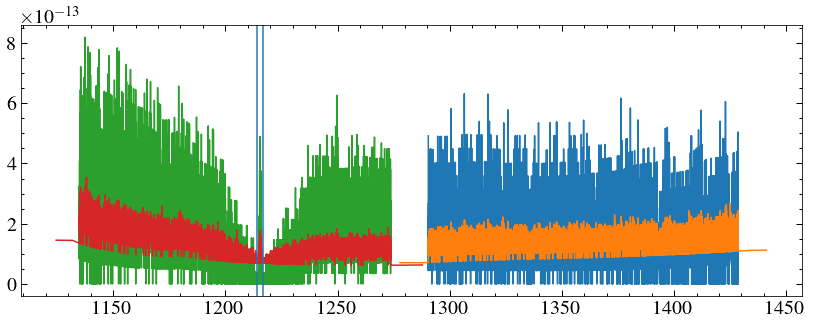

In [20]:
data = fits.getdata(newx1ds[0], 1)
for dt in data:
    #plt.plot(dt['WAVELENGTH'], dt['FLUX'])
    plt.plot(dt['WAVELENGTH'][dt['DQ'] == 0], dt['FLUX'][dt['DQ'] == 0])
    plt.plot(dt['WAVELENGTH'], dt['ERROR'])
lya = [1214, 1217]
[plt.axvline(line) for line in lya]
#plt.xlim(1210, 1220)

In [33]:
fits.getheader(newx1ds[0], 1)

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =              1409040 / length of dimension 1                          
NAXIS2  =                    2 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   20 / number of table fields                         
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1 / extension version number                       
ROOTNAME= 'ldlc01xvq                         ' / rootname of the observation set
EXPNAME = 'ldlc01xvq        

In [31]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff = np.insert(diff, 0, diff[0]) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff/2.
    w1 = w + diff/2.
    return w0, w1

lya = [1214, 1217]
time = [] #arrays to put the light curve in
flux = []
error = []
for x in newx1ds:
    hdr= fits.getheader(x, 1)
    data = fits.getdata(x,1)
    ti = (hdr['EXPSTART'] + hdr['EXPEND'])/2
    time.append(ti)
    fi = 0
    ei = 0
    for dt in data:
        w, f, e , dq = (dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ'])
        w0, w1 = wavelength_edges(w) 
        mask  = (w < lya[0]) | (w > lya[1]) & (dq == 0)
        w0, w1, f, e = w0[mask], w1[mask], f[mask], e[mask]
        fi += np.sum(f*(w1-w0))
        ei += (np.sum(e**2 * (w1-w0)**2))**0.5
    flux.append(fi)
    error.append(ei)
        
    
time, flux, error = np.array(time), np.array(flux), np.array(error)


        

(170.22, 170.26)

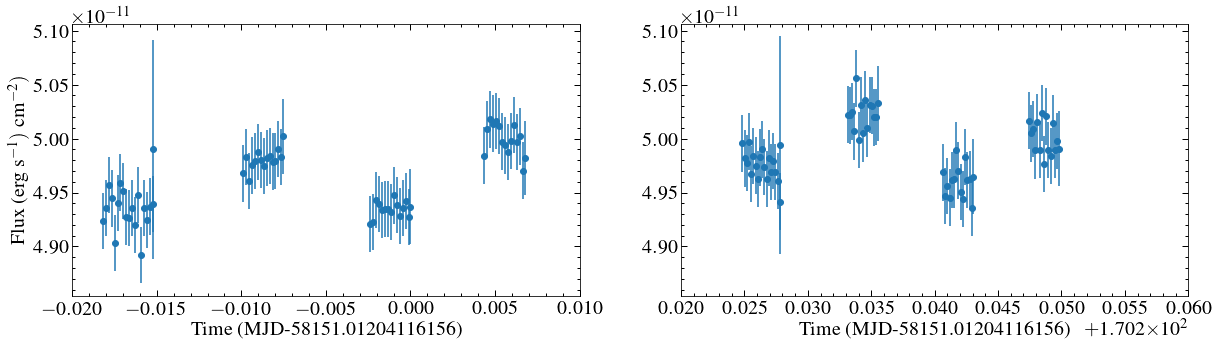

In [30]:
t0 = time[0]
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.errorbar(time-t0, flux, yerr = error, marker='o', ls='none') #plot the light curve
plt.ylabel('Flux (erg s$^{-1})$ cm$^{-2})$')
plt.xlabel('Time (MJD-{})'.format(t0))
plt.xlim(-0.02, 0.01)


plt.subplot(122)
plt.errorbar(time-t0, flux, yerr = error, marker='o', ls='none') #plot the light curve
#plt.ylabel('Flux (erg s$^{-1})$ cm$^{-2})$')
plt.xlabel('Time (MJD-{})'.format(t0))
plt.xlim(170.22, 170.26)

In [32]:
from astropy.table import Table
from astropy.io import ascii
from astropy.units import cds
cds.enable()

save_data = Table([time*cds.MJD, flux/u.s, error/u.s], names = ['TIME', 'FLUX', 'ERROR'])
ascii.write(save_data, '{}_{}s_lc.ecsv'.format('CC_CET_COS', tbin), format = 'ecsv', overwrite=True)